In [1]:
import torch
from pathlib import Path
import numpy as np
from collections import Counter, OrderedDict


In [2]:
import matplotlib.pyplot as plt
plt.style.use('model/lhcb.mplstyle')

In [3]:
#from model.models import AltCNN4Layer_D35_sp as Model
from model.models_mds_G_simon import AllCNN8Layer_Ca_Two_KDE_withPcnn as Model

from model.collectdata import collect_data, collect_truth
from model.collectdata_poca_KDE import collect_data_poca

from model.plots import plot_truth_vs_predict
from model.efficiency import efficiency, ValueSet, pv_locations, exact_efficiency
from model.efficiency_res_optimized import filter_nans_res, efficiency_res, ValueSet_res, pv_locations_res, pv_locations_updated_res, get_resolution, get_reco_resolution, get_nTracks_sorted, get_PVs_label, remove_ghosts_PVs, get_std_resolution
from model.training import select_gpu
from model.core import modernize_state

#### Device configuration

In [4]:
# device = select_gpu(2)
device = torch.device("cpu")

#### Load a dataset

In [5]:
valfile_ToyMC = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.h5')
valfile_FullMC = Path('/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5')
'''
WARNING ::: The data type of pv_HLT1CPU_MinBiasMagDown_14Nov.h5 and Oct03_20K_val.h5 
            files are different for some variables: i.e. 
           
'''
truth_ToyMC = collect_truth(valfile_ToyMC)
truth_FullMC = collect_truth(valfile_FullMC)

truth_FullMC_svs = collect_truth(valfile_FullMC, pvs=False)

print('-'*100)           
warn_msg = '\nWARNING ::: The data type of pv_HLT1CPU_MinBiasMagDown_14Nov.h5 and Oct03_20K_val.h5 \nfiles are different for some variables: i.e.\n'
print(warn_msg)           
print('Toy  MC true z:',type(truth_ToyMC.z[0][0]))
print('Full MC true z:',type(truth_FullMC.z[0][0]))

warn_msg = '\nThis causes an issue when calling some of the numba functions in model.efficiency_res.py\n'
print(warn_msg)           
print('-'*100)           


Loaded /share/lazy/schreihf/PvFinder/Oct03_20K_val.h5 in 0.05594 s
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 0.09303 s
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 0.1822 s
----------------------------------------------------------------------------------------------------

files are different for some variables: i.e.

Toy  MC true z: <class 'numpy.float32'>
Full MC true z: <class 'numpy.float64'>

This causes an issue when calling some of the numba functions in model.efficiency_res.py

----------------------------------------------------------------------------------------------------


In [6]:
'''
valfile_ToyMC does not have the necessary info to use collect_data_poca for the moment
'''

#validation_ToyMC = collect_data_poca(valfile_ToyMC,
#                                     batch_size=1,
#                                     device=device,
#                                     slice=slice(20000),
#                                     masking=True, shuffle=False,
#                                     load_XandXsq=False,
#                                     load_A_and_B = True,
#                                     load_xy=True)
                
validation_FullMC_mask = collect_data_poca(valfile_FullMC,
                                      batch_size=1,
                                      device=device,
                                      slice=slice(1000),
                                      masking=True, shuffle=False,
                                      load_XandXsq=False,
                                      load_A_and_B = True,
                                      load_xy=True)
                                                    

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 20.2 s
Constructing 1000 event dataset took 0.01021 s


#### Load the model weights

Modernizing old style models if needed.

In [7]:
model = Model().to(device)
model_dict = model.state_dict()
dict_name = 'ML/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0_final.pyt'
pretrained_dict = torch.load(dict_name)
model_dict.update(pretrained_dict) 
model.load_state_dict(pretrained_dict,strict=False)
model.eval()

AllCNN8Layer_Ca_Two_KDE_withPcnn(
  (softplus): Softplus(beta=1, threshold=20)
  (leaky): LeakyReLU(negative_slope=0.01)
  (relu): LeakyReLU(negative_slope=0.0)
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=F

#### Compute the model and move results to Numpy

In [8]:
%%time
with torch.no_grad():
    outputs_FullMC_mask = model(validation_FullMC_mask.dataset.tensors[0]).cpu().numpy()
    labels_FullMC_mask = validation_FullMC_mask.dataset.tensors[1].cpu().numpy()    

x0 =  tensor([[2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.9257e-19, 2.8086e-19, 2.3365e-19,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [6.2566e-28, 4.6653e-30, 2.6249e-32,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        ...,
        [8.0241e-29, 4.2375e-31, 1.4098e-33,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17]])
x1 =  tensor([[ 0.1092,  0.1095,  0.1098,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.0960,  0.0961,  0.0960,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.0907,  0.0895,  0.0880,  ..., -0.0398, -0.0137,  0.0103],
        ...,
        [-0.0261, -0.0623, -0.1029,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.1092,  0.1095,  0.1098,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.1092,  0.1095,  0

In [10]:
nsig_res_FHWM = 5 #2.335
steps_extrapolation = 10
ratio_max = 0.5

nsig_res_std = 5.0
f_ratio_window = 0.01
nbins_lookup = 20

z_ghosts = 10
h_ghosts = 2.0

nsig_res_nTcks = 5
min_res = 0.0
threshold = 0.06
integral_threshold = 0.75
min_width = 0


eff_settings_res_top = dict(
                        nsig_res_nTrcks=nsig_res_nTcks, # number of sigmas from original res(nTracks)
                        min_res=min_res, # 
                        threshold=threshold,
                        integral_threshold=integral_threshold,
                        min_width = min_width, #bins
                        debug = 0,     # bins
                        )

pv_loc_settings_top = dict(
    threshold=threshold,
    integral_threshold=integral_threshold,
    min_width=min_width# bins
)
eff_settings_CHEP = dict(
    difference = 5., # bins
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)


In [11]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


output_folder = 'ML_dir/KDE_to_Hist/Model_18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0/'
output_path = Path(output_folder)
output_path.mkdir(exist_ok=True)


iEvt =  0
pv_sorted[ii][0] -75.9433
(pv_sorted[ii][0]-zmin) 124.0567
inv_binw*(pv_sorted[ii][0]-zmin) 1240.567
pv_sorted[ii][0] -53.5683
(pv_sorted[ii][0]-zmin) 146.4317
inv_binw*(pv_sorted[ii][0]-zmin) 1464.317
pv_sorted[ii][0] -22.578
(pv_sorted[ii][0]-zmin) 177.422
inv_binw*(pv_sorted[ii][0]-zmin) 1774.22
pv_sorted[ii][0] -13.2912
(pv_sorted[ii][0]-zmin) 186.7088
inv_binw*(pv_sorted[ii][0]-zmin) 1867.088
pv_sorted[ii][0] -3.9851
(pv_sorted[ii][0]-zmin) 196.0149
inv_binw*(pv_sorted[ii][0]-zmin) 1960.1490000000001
pv_sorted[ii][0] 12.2541
(pv_sorted[ii][0]-zmin) 212.2541
inv_binw*(pv_sorted[ii][0]-zmin) 2122.541
pv_sorted[ii][0] 19.3484
(pv_sorted[ii][0]-zmin) 219.3484
inv_binw*(pv_sorted[ii][0]-zmin) 2193.484
pv_sorted[ii][0] 29.4695
(pv_sorted[ii][0]-zmin) 229.4695
inv_binw*(pv_sorted[ii][0]-zmin) 2294.695
pv_sorted[ii][0] 55.7932
(pv_sorted[ii][0]-zmin) 255.7932
inv_binw*(pv_sorted[ii][0]-zmin) 2557.9320000000002
pv_sorted[ii][0] 74.7049
(pv_sorted[ii][0]-zmin) 274.7049
inv_binw*(p

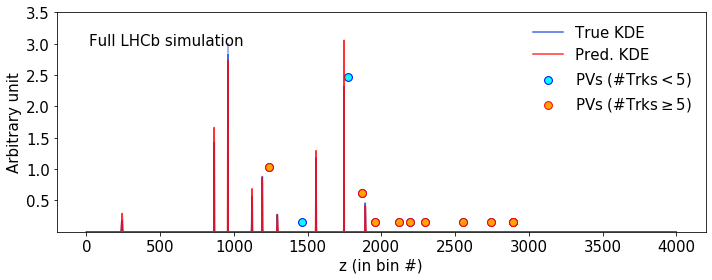

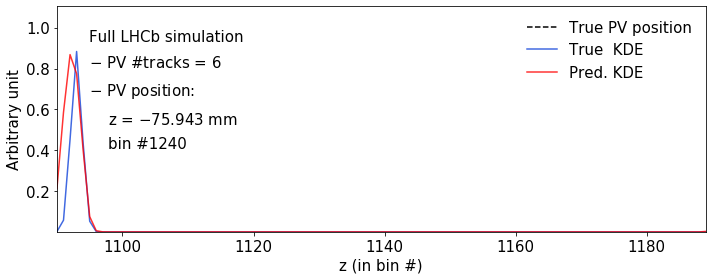

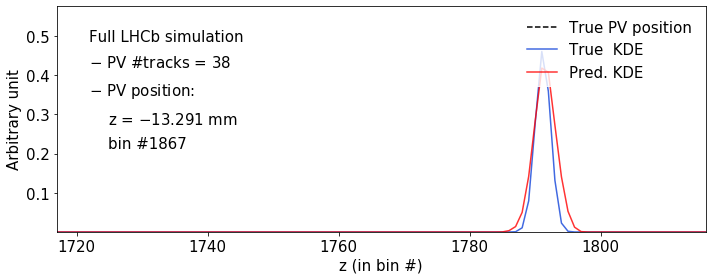

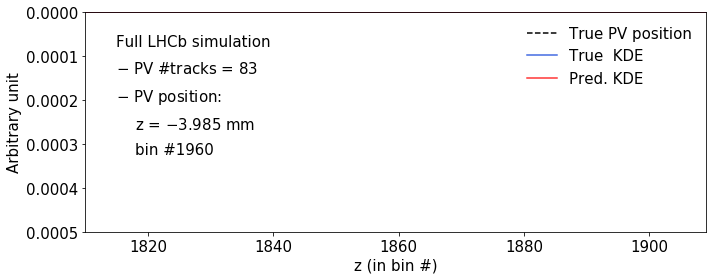

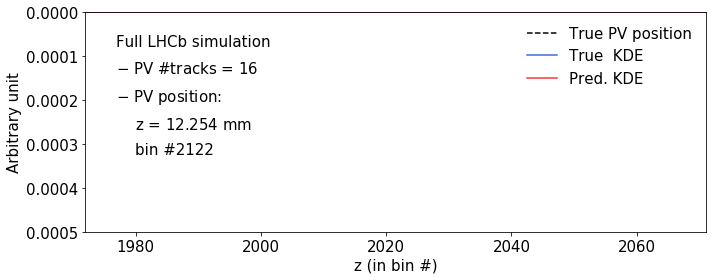

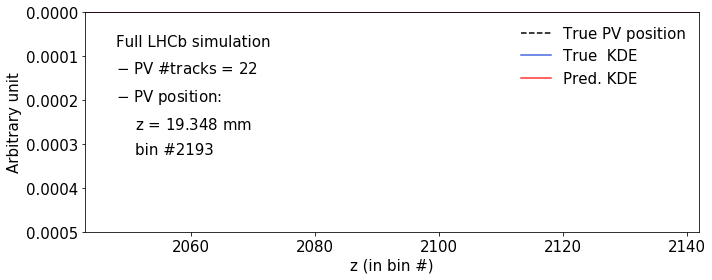

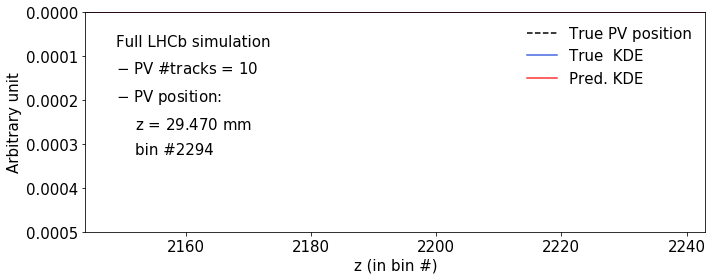

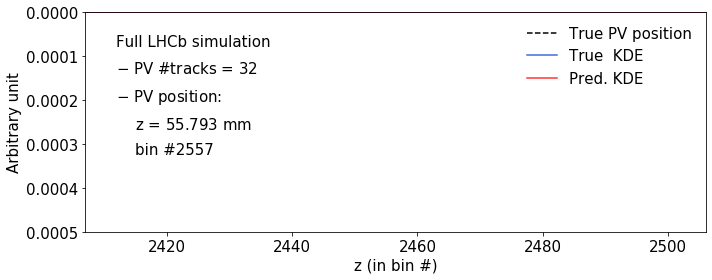

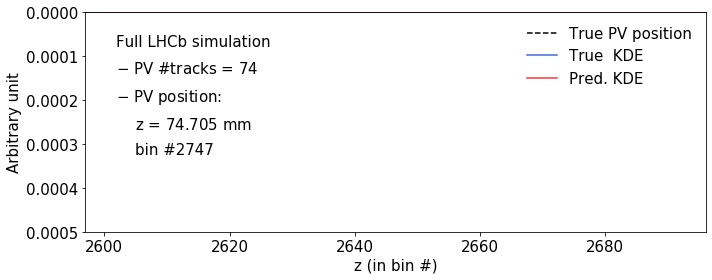

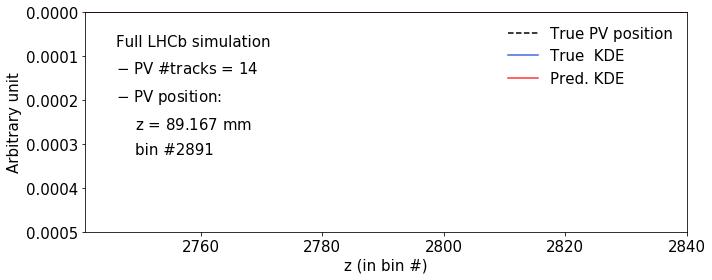

In [26]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plotSV=False
nTracks_good_PV=5

plt_name = ''
fsize = 15
fsize_ax = 15

zmin = -200
zmax = 200

shift = 100

#zmin=zmin-shift
#zmax=zmax-shift

nKDEbins = 4000
binw = (zmax-zmin)/float(nKDEbins)
inv_binw = 1./binw

for iEvt in range(1):
    
    print("iEvt = ",iEvt)

    # --- Retrieve the TRUE KDEs
    y_kde = labels_FullMC_mask[iEvt]

    # --- Retrieve the PREDICTED KDEs for each trained model (iteration over same model)
    y_pred = outputs_FullMC_mask[iEvt]

    # --- Containers usefull for plotting
    pv_sorted = sorted(zip(truth_FullMC.z[iEvt],truth_FullMC.cat[iEvt],truth_FullMC.n[iEvt]), key=lambda x: x[0])
    n_pvs = len(pv_sorted)
    good_pvs = []
    good_pv_bins = []
    pv_sorted_bins = []

    # --- LOOP over all PVs
    for ii in range(n_pvs):

        pv_sorted_bins.append(np.floor(inv_binw*(pv_sorted[ii][0]-zmin)))
        
        print("pv_sorted[ii][0]",pv_sorted[ii][0])
        print("(pv_sorted[ii][0]-zmin)",(pv_sorted[ii][0]-zmin))
        print("inv_binw*(pv_sorted[ii][0]-zmin)",inv_binw*(pv_sorted[ii][0]-zmin))
        
        # PV with at least 5 tracks are considered as good PVs
        # Can also filter using "pv_sorted[ii][1]", which is a boolean at 1 if nTracks_good_PV is >= 5
        if pv_sorted[ii][2]>=nTracks_good_PV:
            good_pvs.append(pv_sorted[ii])
            good_pv_bins.append(np.floor(inv_binw*(pv_sorted[ii][0]-zmin)))

    n_good_pv_bins = len(good_pv_bins)

    sv_sorted = sorted(zip(truth_FullMC_svs.z[iEvt],truth_FullMC_svs.cat[iEvt],truth_FullMC_svs.n[iEvt]), key=lambda x: x[0])
    n_svs = len(sv_sorted)
    sv_sorted_bins = []
    # --- LOOP over all SVs
    for ii in range(n_svs):
        sv_sorted_bins.append(np.floor(inv_binw*(sv_sorted[ii][0]-zmin)))
            
    # ==============================
    # --- Start plotting things here
    # ==============================
    fig, ax = plt.subplots()
    max_y_kde = max(y_kde)
    max_y_pred = max(y_pred)

    #print(max_y_kde,max_y_pred)
    max_y = max(max_y_kde,max_y_pred)
    #print(max_y)

    plt.ylim(0.0005,1.15*max_y)

    pvstr = "PVs" # tag for the text box info on the plot
    if len(good_pv_bins)<=1:
        pvstr = "PV"

    # --- Add the true KDE distribution
    plt.plot(y_kde, color="royalblue", label="True KDE")

    # --- Add the predicted KDE distributions (for each model iteration)
    plt.plot(y_pred, color="red", alpha = 0.8, label="Pred. KDE")

    # --- Add markers showing the PVs position
    # - LOOP over all PVs
    for ipv in range(n_pvs):
        xPV = pv_sorted_bins[ipv]
        if xPV<0:
            continue
        yPV = max(y_kde[int(xPV)-50:int(xPV)+50]) + 0.05*max_y
        plt.scatter((xPV),(yPV), s=61, marker = "o", color="blue", facecolor="cyan")
        #color = 'blue', marker = "o", markersize=8, markerfacecolor="cyan"
    # Add once more the last PV with the label for legend purpose (not ideal, but it works...)
    if n_pvs>n_good_pv_bins:
        plt.scatter((xPV),(yPV), s=61, marker = "o", color="blue", facecolor="cyan", label='%s (#Trks$<%s$)'%(pvstr,nTracks_good_PV))

    # - LOOP over good PVs
    for ipv in range(n_good_pv_bins):
        xPV = good_pv_bins[ipv]
        if xPV<0:
            continue
        yPV = max(y_kde[int(xPV)-50:int(xPV)+50]) + 0.05*max_y
        plt.scatter((xPV),(yPV), s=61, marker="o", color="red", facecolor="orange")
    # Add once more the last goo PV with the label for legend purpose (not ideal, but it works...)
    plt.scatter((xPV),(yPV), s=61, marker="o", color="red", facecolor="orange", label='%s (#Trks$\geq%s$)'%(pvstr,nTracks_good_PV))

    # - LOOP over all SVs
    if plotSV:
        for isv in range(n_svs):
            xSV = sv_sorted_bins[isv]
            ySV = max(y_kde[int(xSV)-50:int(xSV)+50]) + 0.1*max_y
            plt.scatter((xSV),(ySV), s=41, marker = "o", color="darkgreen", facecolor="limegreen")
            #color = 'blue', marker = "o", markersize=8, markerfacecolor="cyan"
        # Add once more the last PV with the label for legend purpose (not ideal, but it works...)
        if n_svs>0:
            plt.scatter((xSV),(ySV), s=41, marker = "o", color="darkgreen", facecolor="limegreen", label='SVs')

    # --- Add the legend (in the upper-right corner: 'loc=1')
    plt.legend(loc=1, facecolor='white', edgecolor='white', fontsize=fsize)

    # --- Text box info added on the top left part of the plot, with
    # - event number
    # - number of good PVs out of the total number of PVs for the event
    textstr = '\n'.join((
    r'Full LHCb simulation',     
    #r'Toy MC simulation',     
    #r'',     
    #r'Evt #%s' % (iEvt, ),     
    #r'$-$ %s good %s (of %s)' %(len(good_pv_bins),pvstr,len(pv_sorted)) 
    ))              
    props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
    ax.text(0.05, 0.90, textstr, transform=ax.transAxes,verticalalignment='top', bbox=props,linespacing = 1.8, fontsize=fsize)

    # --- Set the plot x- and y-axis labels
    ax.set_xlabel("z (in bin #)", fontsize=fsize_ax)
    ax.set_ylabel("Arbitrary unit", fontsize=fsize_ax)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fsize_ax)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fsize_ax)

    # --- Save the plot 
    fname = 'Evt%s'%(iEvt)
    plt.savefig(str(output_path / f'{fname}.png'))
    plt.savefig(str(output_path / f'{fname}.pdf'))

    # =====================================================
    # =====================================================
    # --- Make the zoomed in plots for each of the good PV
    # =====================================================
    # =====================================================
    for jj in range(n_good_pv_bins):
        if good_pvs[jj][0]<zmin or good_pvs[jj][0]>zmax:
            continue
        print("PV position and bin # = ", good_pvs[jj], good_pv_bins[jj])

        # Low bin number edge
        nLow =  int(good_pv_bins[jj]-50)
        # High bin number edge
        nHigh = int(good_pv_bins[jj]+50)
        # Set the range of x according to the low bin edge + 100 bins, 
        # i.e. a list of 100 values iterating 1 from nLow
        x=[(i+nLow) for i in range(100)]

        fig, ax = plt.subplots()
        plt.xlim(x[0],x[99])
        plt.ylim(0.0005,1.25*max([max(y_pred[nLow:nHigh]),max(y_kde[nLow:nHigh])]))

        # --- Add vertical line showing the good PV position
        plt.axvline(x=good_pv_bins[jj], color='black', linestyle='dashed', label="True PV position")

        if plotSV:
            SVhere = False
            for isv in range(n_svs):
                xSV = sv_sorted_bins[isv]
                if xSV >= x[0] and xSV <= x[99]:
                    if not SVhere:
                        plt.axvline(x=xSV, color='grey', linestyle='dotted', label="True SV position")
                        SVhere = True
                    else:
                        plt.axvline(x=xSV, color='grey', linestyle='dotted')


        # --- Add the true KDE distribution
        plt.plot(x,y_kde[nLow:nHigh], color="royalblue", label="True  KDE")

        # --- Add the predicted KDE distributions (for each model iteration)
        plt.plot(x,y_pred[nLow:nHigh], color="red", alpha = 0.8, label="Pred. KDE")

        # --- Add the legend (in the upper-right corner: 'loc=1')
        plt.legend(loc=1, facecolor='white', edgecolor='white', fontsize=fsize)

        # --- Text box info added on the top left part of the plot, with
        # - PV number
        # - number of tracks origiating from the PV
        # - PV position (in z and bin number)
        textstr = '\n'.join((
        r'Full LHCb simulation',     
        #r'Toy MC simulation',     
        #r'',     
        #r'Evt #%s' % (iEvt, ),     
        #r'$-$ PV #%s (of %s)' %(jj+1,n_good_pv_bins ),
        r'$-$ PV #tracks = %s' % (good_pvs[jj][2], ),     
        r'$-$ PV position:',              
        r'    z = $%.3f$ mm' % (good_pvs[jj][0]),             
        r'    bin #%.0f' % (good_pv_bins[jj])))              
        #r'PV_bin = %.0f' % (good_pv_bins[jj], )))            
        props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
        ax.text(0.05, 0.90, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props, linespacing = 1.8, fontsize=fsize)
        ax.set_xlabel("z (in bin #)", fontsize=fsize_ax)
        ax.set_ylabel("Arbitrary unit", fontsize=fsize_ax)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fsize_ax)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fsize_ax)
        fname = 'Evt%s_goodPV%s'%(iEvt,jj)
        plt.savefig(str(output_path / f'{fname}.png'))
        plt.savefig(str(output_path / f'{fname}.pdf'))


iEvt =  0
PV position and bin # =  (-75.9433, 1, 6) 240.0
PV position and bin # =  (-13.2912, 1, 38) 867.0
PV position and bin # =  (-3.9851, 1, 83) 960.0
PV position and bin # =  (12.2541, 1, 16) 1122.0
PV position and bin # =  (19.3484, 1, 22) 1193.0
PV position and bin # =  (29.4695, 1, 10) 1294.0
PV position and bin # =  (55.7932, 1, 32) 1557.0
PV position and bin # =  (74.7049, 1, 74) 1747.0
PV position and bin # =  (89.1668, 1, 14) 1891.0
iEvt =  1
PV position and bin # =  (-53.4831, 1, 24) 465.0
PV position and bin # =  (4.7732, 1, 21) 1047.0
PV position and bin # =  (10.4657, 1, 116) 1104.0
PV position and bin # =  (73.5192, 1, 14) 1735.0
PV position and bin # =  (99.0496, 1, 20) 1990.0
PV position and bin # =  (108.8508, 1, 11) 2088.0
iEvt =  2
PV position and bin # =  (-65.9665, 1, 40) 340.0
PV position and bin # =  (-54.5534, 1, 20) 454.0
PV position and bin # =  (21.6266, 1, 196) 1216.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (81.7798, 1, 49) 1817.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iEvt =  3


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-66.2543, 1, 34) 337.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-44.3162, 1, 32) 556.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (15.2063, 1, 55) 1152.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (24.9457, 1, 52) 1249.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (33.5691, 1, 42) 1335.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iEvt =  4


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-69.8834, 1, 60) 301.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-68.958, 1, 34) 310.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (55.5559, 1, 15) 1555.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (84.1045, 1, 71) 1841.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iEvt =  5


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-79.8148, 1, 121) 201.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-66.4897, 1, 17) 335.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (40.5364, 1, 65) 1405.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (149.7557, 1, 28) 2497.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iEvt =  6


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (-39.6572, 1, 87) 603.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (29.3735, 1, 38) 1293.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (32.288, 1, 17) 1322.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PV position and bin # =  (43.719, 1, 36) 1437.0


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iEvt =  7


/data/conda/envs/pvfinder/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ValueError: max() arg is an empty sequence

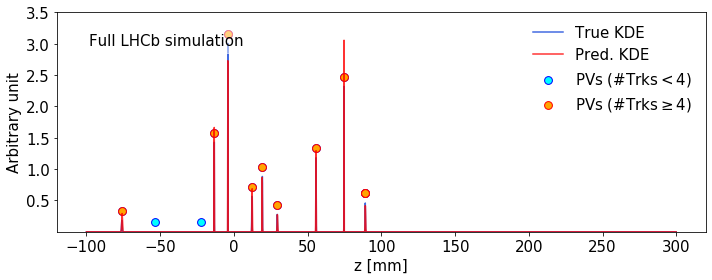

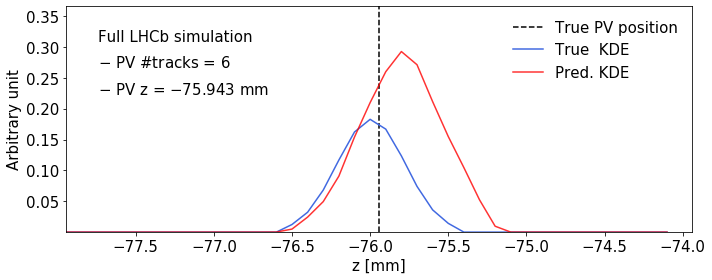

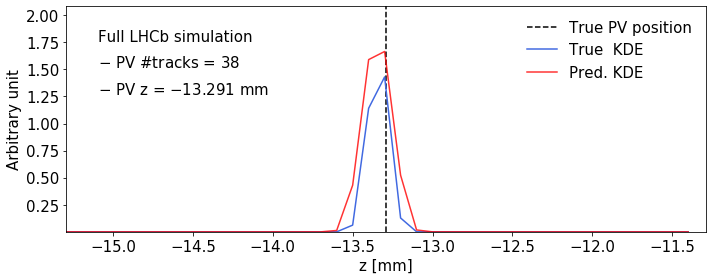

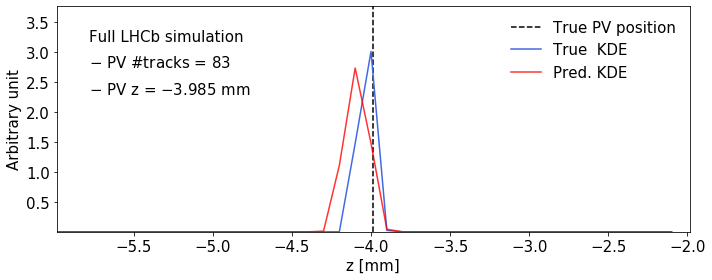

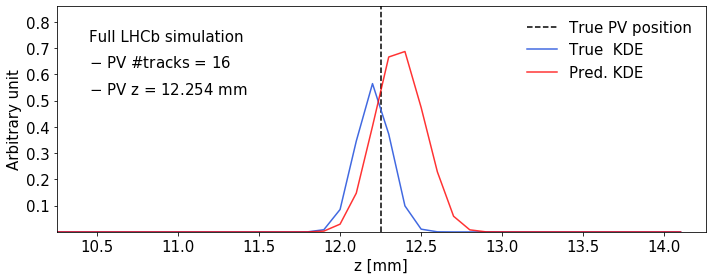

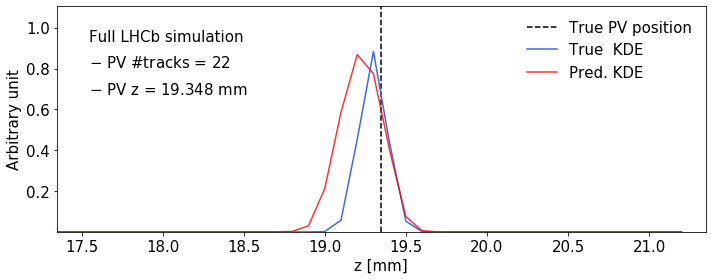

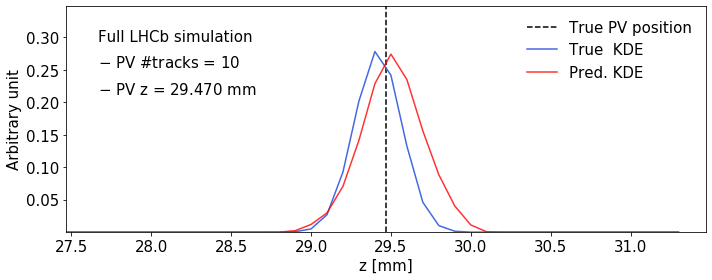

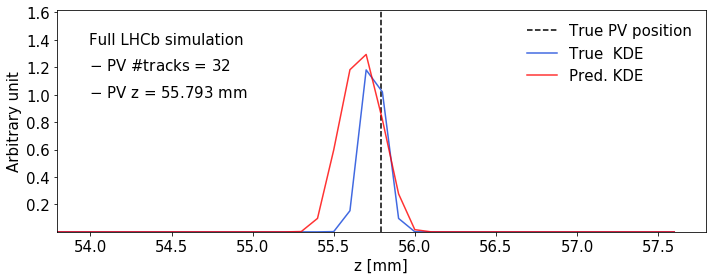

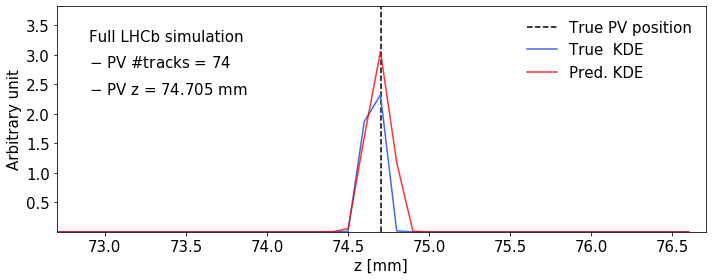

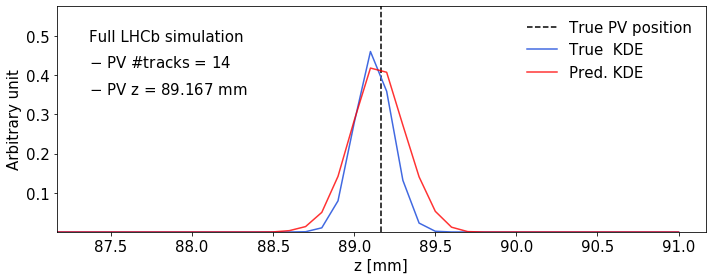

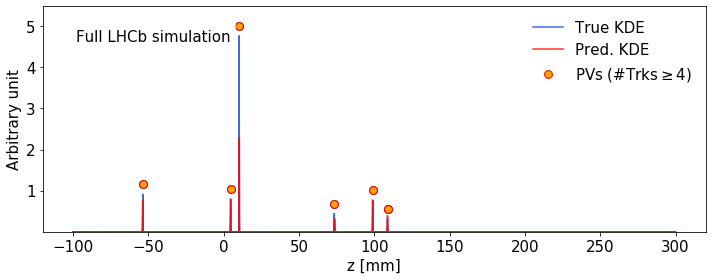

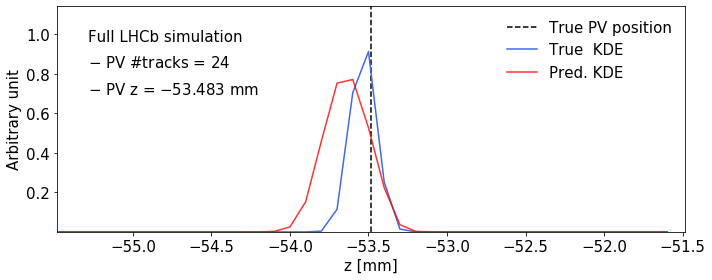

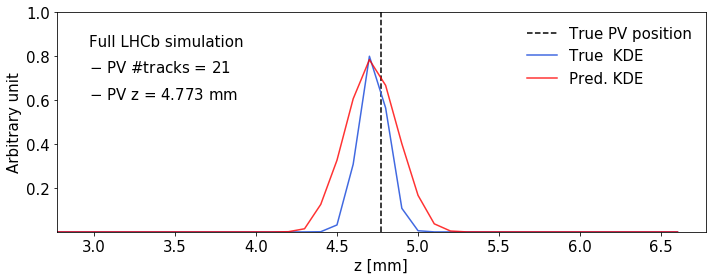

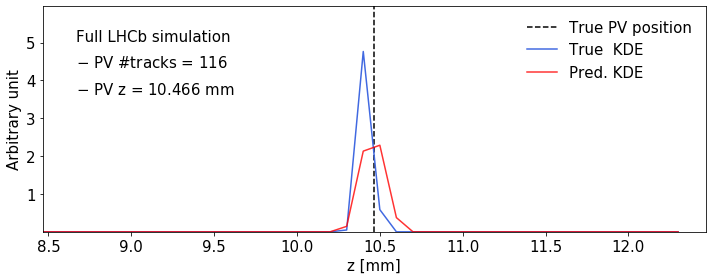

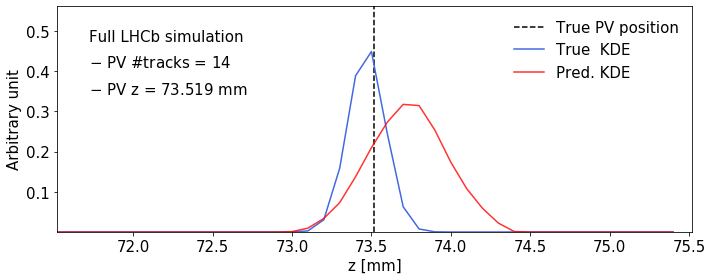

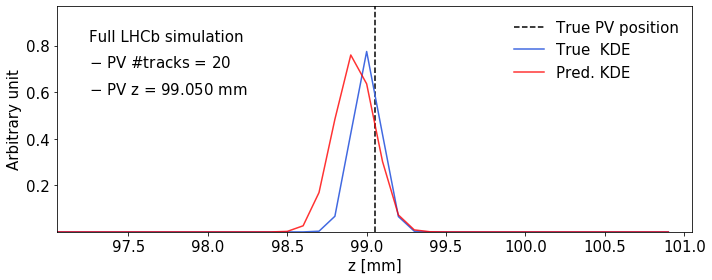

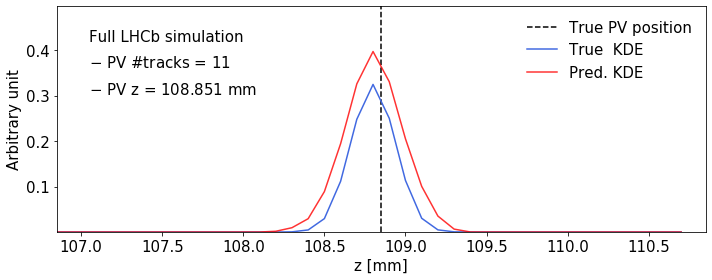

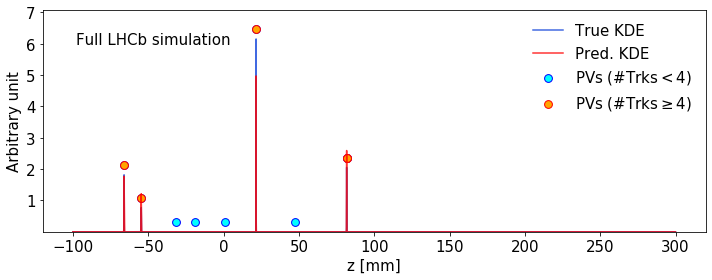

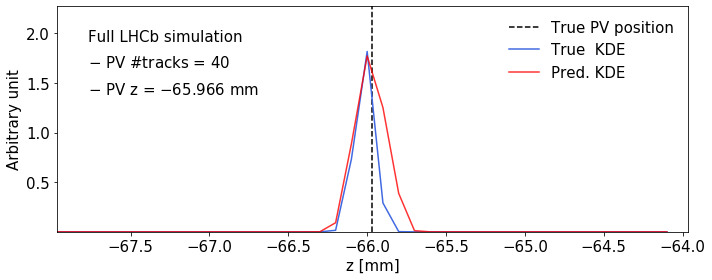

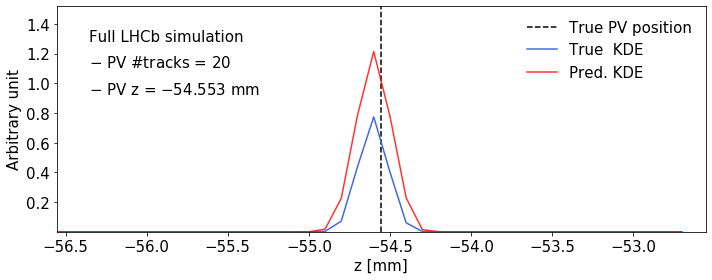

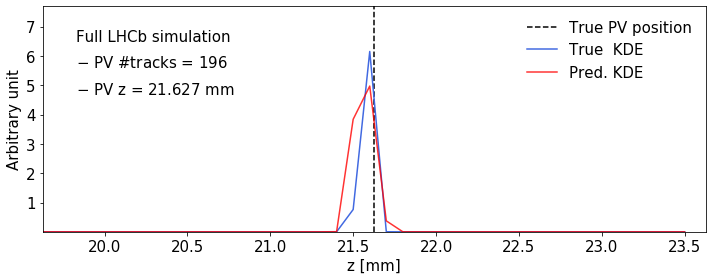

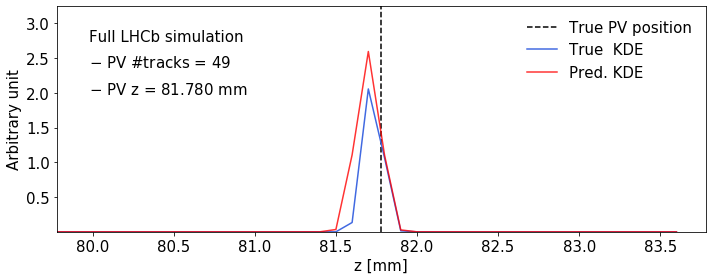

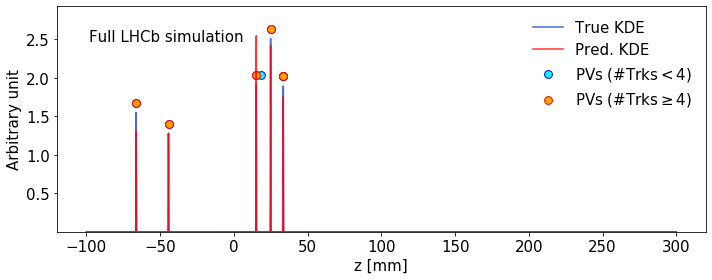

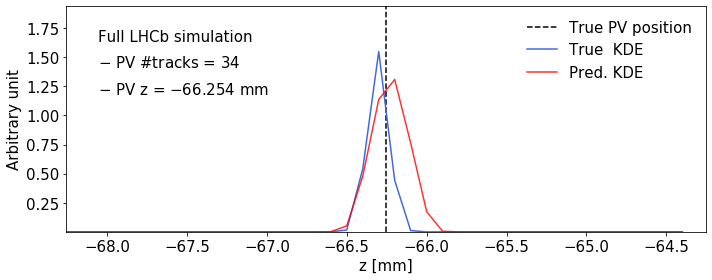

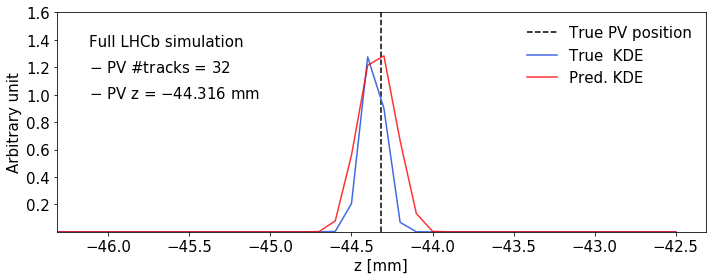

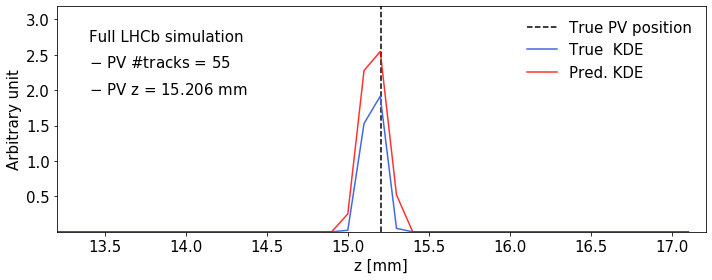

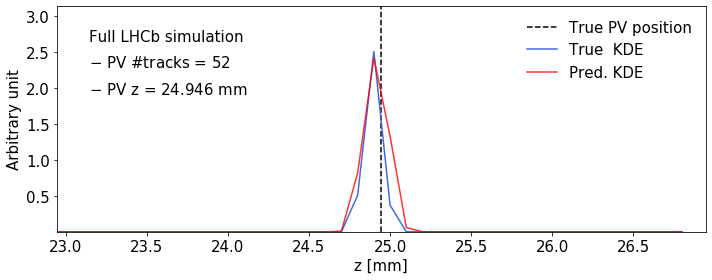

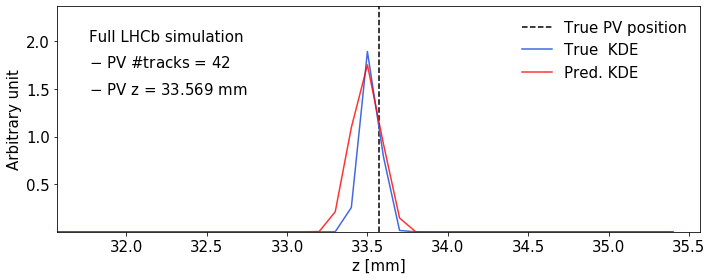

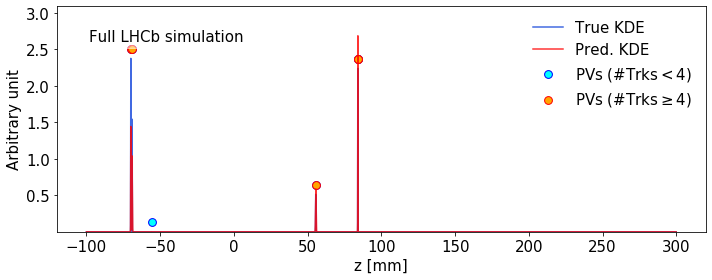

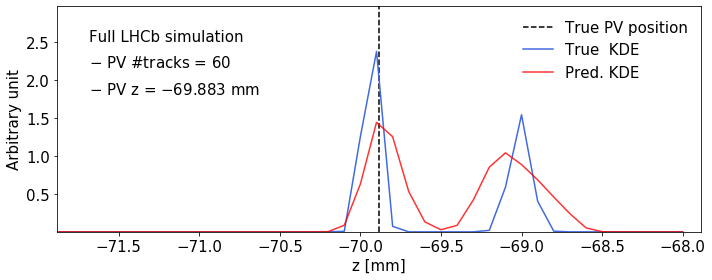

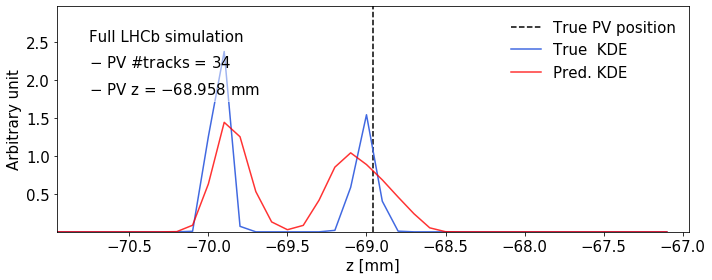

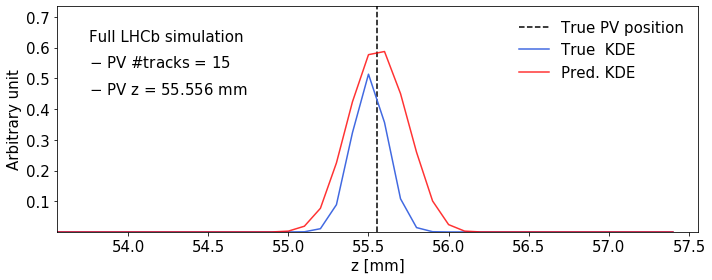

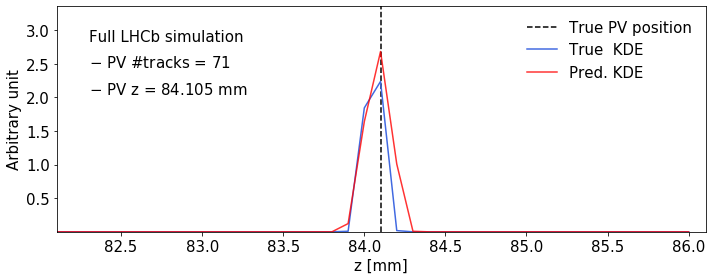

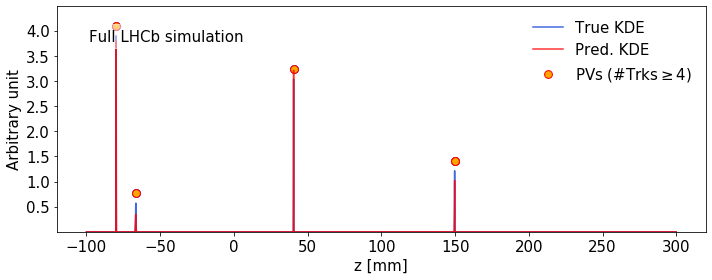

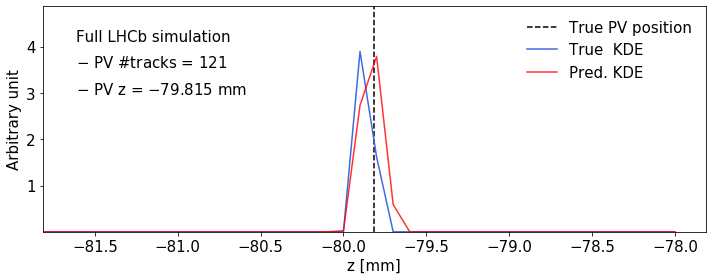

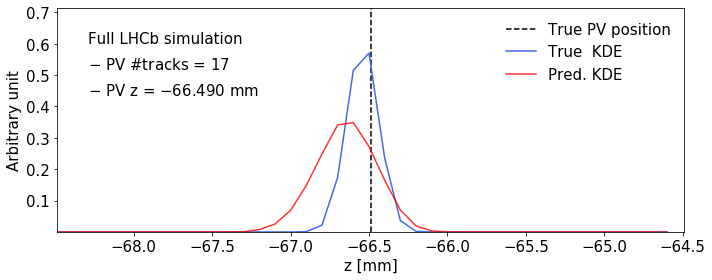

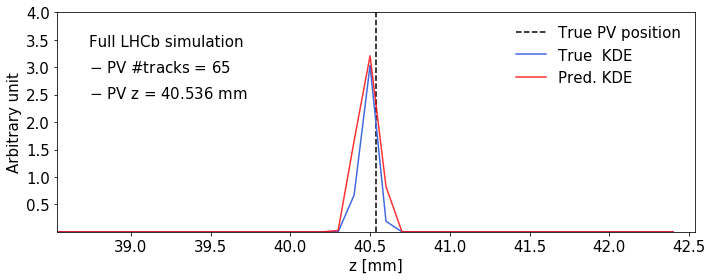

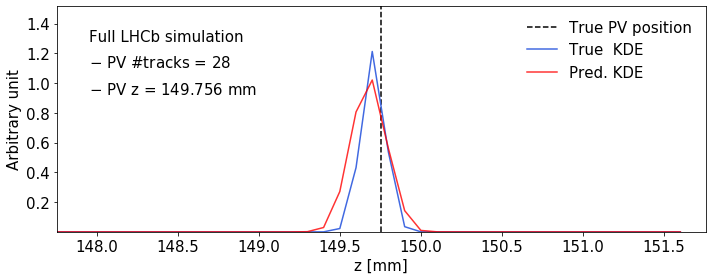

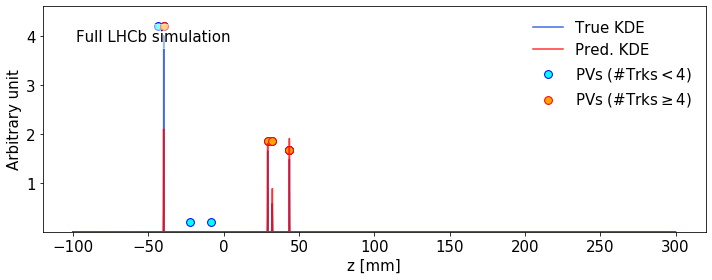

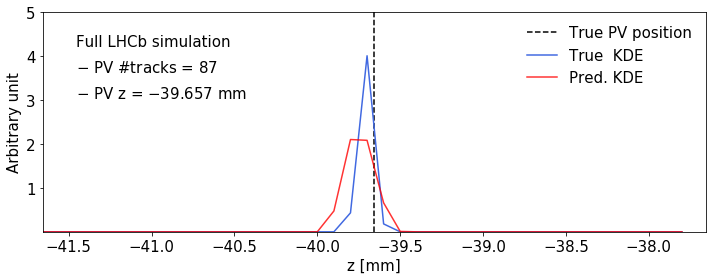

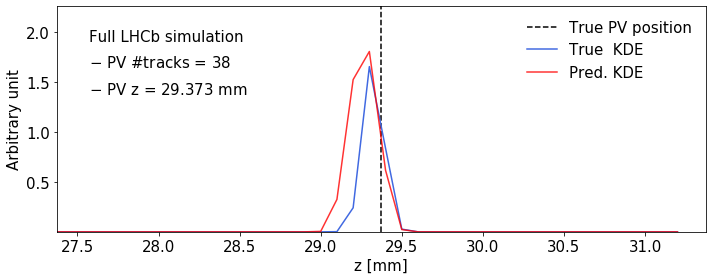

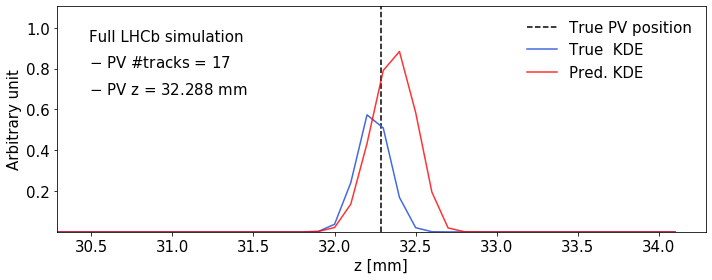

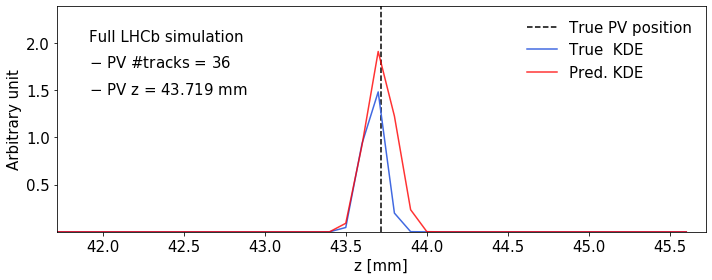

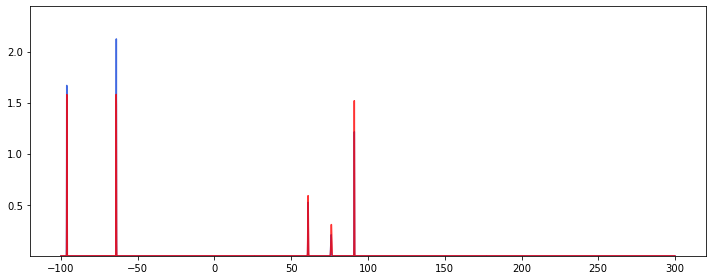

In [76]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plotSV=False
nTracks_good_PV=4

plt_name = ''
fsize = 15
fsize_ax = 15

zmin = -100
zmax = 300

nKDEbins = 4000
binw = (zmax-zmin)/float(nKDEbins)
inv_binw = 1./binw

x_KDE = [(i*binw)+zmin for i in range(nKDEbins)]

for iEvt in range(10):
    
    print("iEvt = ",iEvt)

    # --- Retrieve the TRUE KDEs
    y_kde = labels_FullMC_mask[iEvt]
    
    # --- Retrieve the PREDICTED KDEs for each trained model (iteration over same model)
    y_pred = outputs_FullMC_mask[iEvt]

    # --- Containers usefull for plotting
    pv_sorted = sorted(zip(truth_FullMC.z[iEvt],truth_FullMC.cat[iEvt],truth_FullMC.n[iEvt]), key=lambda x: x[0])
    n_pvs = len(pv_sorted)
    good_pvs = []
    good_pv_bins = []
    pv_sorted_bins = []

    # --- LOOP over all PVs
    for ii in range(n_pvs):

        pv_sorted_bins.append(np.floor(inv_binw*(pv_sorted[ii][0]-zmin)))
        
        #print("pv_sorted[ii][0]",pv_sorted[ii][0])
        #print("(pv_sorted[ii][0]-zmin)",(pv_sorted[ii][0]-zmin))
        #print("inv_binw*(pv_sorted[ii][0]-zmin)",inv_binw*(pv_sorted[ii][0]-zmin))
        
        # PV with at least 5 tracks are considered as good PVs
        # Can also filter using "pv_sorted[ii][1]", which is a boolean at 1 if nTracks_good_PV is >= 5
        if pv_sorted[ii][2]>=nTracks_good_PV:
            good_pvs.append(pv_sorted[ii])
            good_pv_bins.append(np.floor(inv_binw*(pv_sorted[ii][0]-zmin)))

    n_good_pv_bins = len(good_pv_bins)

    sv_sorted = sorted(zip(truth_FullMC_svs.z[iEvt],truth_FullMC_svs.cat[iEvt],truth_FullMC_svs.n[iEvt]), key=lambda x: x[0])
    n_svs = len(sv_sorted)
    sv_sorted_bins = []
    # --- LOOP over all SVs
    for ii in range(n_svs):
        sv_sorted_bins.append(np.floor(inv_binw*(sv_sorted[ii][0]-zmin)))
            
    # ==============================
    # --- Start plotting things here
    # ==============================
    fig, ax = plt.subplots()
    max_y_kde = max(y_kde)
    max_y_pred = max(y_pred)

    #print(max_y_kde,max_y_pred)
    max_y = max(max_y_kde,max_y_pred)
    #print(max_y)

    plt.ylim(0.0005,1.15*max_y)

    pvstr = "PVs" # tag for the text box info on the plot
    if len(good_pv_bins)<=1:
        pvstr = "PV"

    # --- Add the true KDE distribution
    plt.plot(x_KDE,y_kde, color="royalblue", label="True KDE")

    # --- Add the predicted KDE distributions (for each model iteration)
    plt.plot(x_KDE,y_pred, color="red", alpha = 0.8, label="Pred. KDE")

    
    # --- Add markers showing the PVs position
    # - LOOP over all PVs
    for ipv in range(n_pvs):
        if pv_sorted[ipv][0]<zmin or pv_sorted[ipv][0]>zmax:
            continue
            
        if (int((xPV-zmin)/binw)-50)<zmin:
            continue
        xPV = pv_sorted[ipv][0]
        
        #print(xPV)
        #print(int((xPV-zmin)/binw))
        yPV = max(y_kde[int((xPV-zmin)/binw)-50:int((xPV-zmin)/binw)+50]) + 0.05*max_y
        plt.scatter((xPV),(yPV), s=61, marker = "o", color="blue", facecolor="cyan")
        #color = 'blue', marker = "o", markersize=8, markerfacecolor="cyan"
    # Add once more the last PV with the label for legend purpose (not ideal, but it works...)
    if n_pvs>n_good_pv_bins:
        plt.scatter((xPV),(yPV), s=61, marker = "o", color="blue", facecolor="cyan", label='%s (#Trks$<%s$)'%(pvstr,nTracks_good_PV))

    # - LOOP over good PVs
    for ipv in range(n_good_pv_bins):
        if good_pvs[ipv][0]<zmin or good_pvs[ipv][0]>zmax:
            continue
        xPV = good_pvs[ipv][0]
        yPV = max(y_kde[int((xPV-zmin)/binw)-50:int((xPV-zmin)/binw)+50]) + 0.05*max_y
        plt.scatter((xPV),(yPV), s=61, marker="o", color="red", facecolor="orange")
    # Add once more the last goo PV with the label for legend purpose (not ideal, but it works...)
    plt.scatter((xPV),(yPV), s=61, marker="o", color="red", facecolor="orange", label='%s (#Trks$\geq%s$)'%(pvstr,nTracks_good_PV))

    # - LOOP over all SVs
    if plotSV:
        for isv in range(n_svs):
            xSV = sv_sorted_bins[isv]
            ySV = max(y_kde[int(xSV)-50:int(xSV)+50]) + 0.1*max_y
            plt.scatter((xSV),(ySV), s=41, marker = "o", color="darkgreen", facecolor="limegreen")
            #color = 'blue', marker = "o", markersize=8, markerfacecolor="cyan"
        # Add once more the last PV with the label for legend purpose (not ideal, but it works...)
        if n_svs>0:
            plt.scatter((xSV),(ySV), s=41, marker = "o", color="darkgreen", facecolor="limegreen", label='SVs')

    # --- Add the legend (in the upper-right corner: 'loc=1')
    plt.legend(loc=1, facecolor='white', edgecolor='white', fontsize=fsize)

    # --- Text box info added on the top left part of the plot, with
    # - event number
    # - number of good PVs out of the total number of PVs for the event
    textstr = '\n'.join((
    r'Full LHCb simulation',     
    #r'Toy MC simulation',     
    #r'',     
    #r'Evt #%s' % (iEvt, ),     
    #r'$-$ %s good %s (of %s)' %(len(good_pv_bins),pvstr,len(pv_sorted)) 
    ))              
    props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
    ax.text(0.05, 0.90, textstr, transform=ax.transAxes,verticalalignment='top', bbox=props,linespacing = 1.8, fontsize=fsize)

    # --- Set the plot x- and y-axis labels
    ax.set_xlabel("z [mm]", fontsize=fsize_ax)
    ax.set_ylabel("Arbitrary unit", fontsize=fsize_ax)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fsize_ax)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fsize_ax)

    # --- Save the plot 
    fname = 'Evt%s'%(iEvt)
    plt.savefig(str(output_path / f'{fname}.png'))
    plt.savefig(str(output_path / f'{fname}.pdf'))

    # =====================================================
    # =====================================================
    # --- Make the zoomed in plots for each of the good PV
    # =====================================================
    # =====================================================
    for jj in range(n_good_pv_bins):
        if good_pvs[jj][0]<zmin or good_pvs[jj][0]>zmax:
            continue
        print("PV position and bin # = ", good_pvs[jj], good_pv_bins[jj])

        # Low bin number edge
        nLow =  int(good_pv_bins[jj]-20)
        # High bin number edge
        nHigh = int(good_pv_bins[jj]+20)
        # Set the range of x according to the low bin edge + 100 bins, 
        # i.e. a list of 100 values iterating 1 from nLow
        x=[((i+nLow)*binw)+zmin for i in range(40)]
        x_z = good_pvs[jj][0]
        
        fig, ax = plt.subplots()
        plt.xlim(x_z-20*binw,x_z+20*binw)
        plt.ylim(0.0005,1.25*max([max(y_pred[nLow:nHigh]),max(y_kde[nLow:nHigh])]))

        data_pred = np.ndarray(0,dtype=float)
        
        for ibin in range(nLow,nHigh):
            data_pred = np.append([ibin for j in range(int(y_pred[ibin]*1000.))],data_pred)
            
        # --- Add vertical line showing the good PV position
        plt.axvline(x_z, color='black', linestyle='dashed', label="True PV position")

        if plotSV:
            SVhere = False
            for isv in range(n_svs):
                xSV = sv_sorted_bins[isv]
                if xSV >= x[0] and xSV <= x[39]:
                    if not SVhere:
                        plt.axvline(x=xSV, color='grey', linestyle='dotted', label="True SV position")
                        SVhere = True
                    else:
                        plt.axvline(x=xSV, color='grey', linestyle='dotted')


        # --- Add the true KDE distribution
        plt.hist(data_pred/1000.)
        plt.plot(x,y_kde[nLow:nHigh], color="royalblue", label="True  KDE")

        # --- Add the predicted KDE distributions (for each model iteration)
        plt.plot(x,y_pred[nLow:nHigh], color="red", alpha = 0.8, label="Pred. KDE")

        # --- Add the legend (in the upper-right corner: 'loc=1')
        plt.legend(loc=1, facecolor='white', edgecolor='white', fontsize=fsize)

        # --- Text box info added on the top left part of the plot, with
        # - PV number
        # - number of tracks origiating from the PV
        # - PV position (in z and bin number)
        textstr = '\n'.join((
        r'Full LHCb simulation',     
        #r'Toy MC simulation',     
        #r'',     
        #r'Evt #%s' % (iEvt, ),     
        #r'$-$ PV #%s (of %s)' %(jj+1,n_good_pv_bins ),
        r'$-$ PV #tracks = %s' % (good_pvs[jj][2], ),     
        r'$-$ PV z = $%.3f$ mm' % (good_pvs[jj][0])))
        #r'    bin #%.0f' % (good_pv_bins[jj])))              
        #r'PV_bin = %.0f' % (good_pv_bins[jj], )))            
        props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
        ax.text(0.05, 0.90, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props, linespacing = 1.8, fontsize=fsize)
        ax.set_xlabel("z [mm]", fontsize=fsize_ax)
        ax.set_ylabel("Arbitrary unit", fontsize=fsize_ax)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fsize_ax)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fsize_ax)
        fname = 'Evt%s_goodPV%s'%(iEvt,jj)
        plt.savefig(str(output_path / f'{fname}.png'))
        plt.savefig(str(output_path / f'{fname}.pdf'))
